<a href="https://colab.research.google.com/github/tannisthaghosh142005-sketch/ShadowFox/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install vaderSentiment pandas matplotlib

In [74]:
#import all required libraries
import warnings
warnings.filterwarnings("ignore")
import os
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
#LOAD THE DATASET
INPUT = '/content/X data.csv'
# Load CSV robustly
if not os.path.exists(INPUT):
    raise FileNotFoundError(f"Input file not found at {INPUT}. Please upload it or change INPUT.")

In [76]:
OUTPUT = '/mnt/data/X_sentiment_results.csv'

In [77]:
FORCE_TEXT_COLUMN = None
FORCE_DATE_COLUMN = None

In [78]:
# This is to handle potential issues with file encoding
for enc in ('utf-8', 'latin-1', 'ISO-8859-1'):
    try:
        df = pd.read_csv(INPUT, encoding=enc, on_bad_lines='skip')
        print(f"Successfully loaded {INPUT} with encoding {enc}. Shape: {df.shape}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

Successfully loaded /content/X data.csv with encoding utf-8. Shape: (162980, 2)


In [79]:
# Auto-detect text column (heuristic)
if FORCE_TEXT_COLUMN:
    if FORCE_TEXT_COLUMN not in df.columns:
        raise ValueError(f"FORCE_TEXT_COLUMN='{FORCE_TEXT_COLUMN}' not found in CSV columns.")
    text_col = FORCE_TEXT_COLUMN
else:
    common_names = ['text','tweet','content','post','message','body','status','full_text','clean_text']
    text_col = None
    for c in common_names:
        if c in df.columns:
            text_col = c
            break
    if text_col is None:
        # longest-average object column
        obj_cols = [c for c in df.columns if df[c].dtype == object]
        best=None; best_len=0
        for c in obj_cols:
            lengths = df[c].dropna().astype(str).map(len)
            if lengths.size==0: continue
            avg = lengths.mean()
            if avg>best_len and df[c].nunique(dropna=True)>5:
                best_len=avg; best=c
        if best is None:
            if not obj_cols:
                raise ValueError("No text-like columns detected. Please provide a text column.")
            best = obj_cols[0]
        text_col = best
print("Using text column:", text_col)
print("Sample rows:")
display(df[[text_col]].head(10)) # Display head as a table

Using text column: clean_text
Sample rows:


,clean_text
0,when modi promised “minimum government maximum...
1,talk all the nonsense and continue all the dra...
2,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...
5,kiya tho refresh maarkefir comment karo
6,surat women perform yagna seeks divine grace f...
7,this comes from cabinet which has scholars lik...
8,with upcoming election india saga going import...
9,gandhi was gay does modi


In [80]:
# Minimal cleaning
url_re = re.compile(r'http\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
rt_re = re.compile(r'\bRT\b')
multispace_re = re.compile(r'\s+')
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s)
    s = url_re.sub('', s)
    s = mention_re.sub('', s)
    s = rt_re.sub('', s)
    s = s.replace('#','')
    s = multispace_re.sub(' ', s).strip()
    return s
df['text_clean'] = df[text_col].apply(clean_text)
print("Text cleaning complete.")

Text cleaning complete.


In [81]:
df.columns

Index(['clean_text', 'category', 'text_clean'], dtype='object')

In [82]:
# Import VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except Exception as e:
    print("VADER not installed. Please run:\n    pip install vaderSentiment\nand re-run the script.")
    raise
analyzer = SentimentIntensityAnalyzer()

In [83]:
# Apply analyzer
def get_scores(t):
    if t is None or t=="":
        return {'neg':0.0, 'neu':1.0, 'pos':0.0, 'compound':0.0}
    return analyzer.polarity_scores(t)

scores = df['text_clean'].fillna('').apply(get_scores)
scores_df = pd.DataFrame(list(scores))
df = df.drop(columns=['neg', 'neu', 'pos', 'compound'], errors='ignore')
df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)
display(df.head(10))

,clean_text,category,text_clean,neg,neu,pos,compound
0,when modi promised “minimum government maximum...,-1.0,when modi promised “minimum government maximum...,0.065,0.781,0.154,0.5267
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,0.184,0.816,0.000,-0.4019
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp to...,0.000,0.772,0.228,0.7096
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,0.187,0.655,0.158,-0.0713
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,0.000,0.808,0.192,0.4754
5,kiya tho refresh maarkefir comment karo,0.0,kiya tho refresh maarkefir comment karo,0.000,1.000,0.000,0.0000
6,surat women perform yagna seeks divine grace f...,0.0,surat women perform yagna seeks divine grace f...,0.000,0.610,0.390,0.7506
7,this comes from cabinet which has scholars lik...,0.0,this comes from cabinet which has scholars lik...,0.000,0.839,0.161,0.3612
8,with upcoming election india saga going import...,1.0,with upcoming election india saga going import...,0.000,0.927,0.073,0.2023
9,gandhi was gay does modi,1.0,gandhi was gay does modi,0.000,1.000,0.000,0.0000


In [84]:
#Labeling
def label(comp):
    if comp >= 0.05: return 'positive'
    if comp <= -0.05: return 'negative'
    return 'neutral'
df['sentiment'] = df['compound'].apply(label)

In [85]:
sentiment_summary = pd.concat([counts, percent], axis=1)
sentiment_summary.columns = ['Count', 'Percentage']
print("\nSentiment Summary:")
display(sentiment_summary)


Sentiment Summary:


,Count,Percentage
sentiment,,
positive,76492,46.93
neutral,35712,21.91
negative,50776,31.15


In [86]:
#Show top positive and negative examples
top_pos = df.sort_values('compound', ascending=False).head(10)[[text_col,'text_clean','compound','pos','neu','neg','sentiment']]
top_neg = df.sort_values('compound', ascending=True).head(10)[[text_col,'text_clean','compound','pos','neu','neg','sentiment']]

In [87]:
# Rename columns for better readability
new_column_names = {
    text_col: 'Original Text',
    'text_clean': 'Cleaned Text',
    'compound': 'Compound Score',
    'pos': 'Positive Score',
    'neu': 'Neutral Score',
    'neg': 'Negative Score',
    'sentiment': 'Sentiment Category'
}
top_pos = top_pos.rename(columns=new_column_names)
top_neg = top_neg.rename(columns=new_column_names)

In [88]:
print("\nTop 10 positive posts:")
display(top_pos) # Display top positive posts as a table
print("\nTop 10 negative posts:")
display(top_neg) # Display top negative posts as a table


Top 10 positive posts:


,Original Text,Cleaned Text,Compound Score,Positive Score,Neutral Score,Negative Score,Sentiment Category
33820,champion champion\neverybody know champion cha...,champion champion everybody know champion cham...,0.9927,0.955,0.045,0.000,positive
131852,♥ narendra modi and proud you and your officia...,♥ narendra modi and proud you and your officia...,0.9904,0.615,0.385,0.000,positive
44491,congratulations and keep tons best wishes comp...,congratulations and keep tons best wishes comp...,0.9889,0.630,0.370,0.000,positive
105334,dont understand kannada but did understand tha...,dont understand kannada but did understand tha...,0.9888,0.605,0.395,0.000,positive
88790,don’ know much about you but modi has shown fa...,don’ know much about you but modi has shown fa...,0.9883,0.493,0.484,0.022,positive
111768,every indian must proud you dear great modi sa...,every indian must proud you dear great modi sa...,0.9877,0.566,0.434,0.000,positive
45587,great invention great efforts great success co...,great invention great efforts great success co...,0.9876,0.788,0.212,0.000,positive
24855,shri narendra modi@ sir you are not only humbl...,shri narendra modi@ sir you are not only humbl...,0.9873,0.554,0.446,0.000,positive
32897,wonderful first view loved the trailer and sup...,wonderful first view loved the trailer and sup...,0.9867,0.600,0.400,0.000,positive
31242,dear friend congratulations and best wishes yo...,dear friend congratulations and best wishes yo...,0.9865,0.609,0.391,0.000,positive



Top 10 negative posts:


,Original Text,Cleaned Text,Compound Score,Positive Score,Neutral Score,Negative Score,Sentiment Category
38241,not just reply pakistan but take action agains...,not just reply pakistan but take action agains...,-0.9944,0.000,0.428,0.572,negative
154442,bjp scams adani power scam balco scam chikki s...,bjp scams adani power scam balco scam chikki s...,-0.9920,0.043,0.344,0.613,negative
113870,gst failed\naadhar card failed\ndemonetisation...,gst failed aadhar card failed demonetisation f...,-0.9915,0.040,0.299,0.661,negative
86525,months old baby raped indoresitapurdelhi gangr...,months old baby raped indoresitapurdelhi gangr...,-0.9904,0.000,0.440,0.560,negative
154648,bjpscams adani power scam balco scam chikki sc...,bjpscams adani power scam balco scam chikki sc...,-0.9903,0.045,0.363,0.592,negative
154601,bjp scamsadani power scam balco scam chikki sc...,bjp scamsadani power scam balco scam chikki sc...,-0.9903,0.045,0.363,0.592,negative
153732,major scams under congress bofors scam 1985 sp...,major scams under congress bofors scam 1985 sp...,-0.9902,0.000,0.348,0.652,negative
76691,the act non violence great deed but gandhi non...,the act non violence great deed but gandhi non...,-0.9896,0.072,0.402,0.526,negative
31649,but you did coal scam\nspectrum scam\nhelicopt...,but you did coal scam spectrum scam helicopter...,-0.9892,0.021,0.485,0.494,negative
105060,modis india has offered nothing but lynchings ...,modis india has offered nothing but lynchings ...,-0.9875,0.070,0.388,0.543,negative


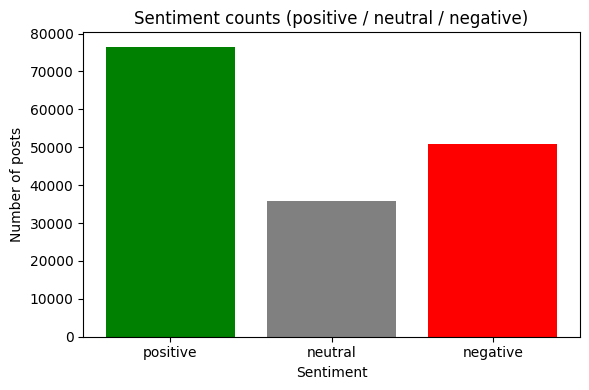

In [89]:
# bar chart
labels = counts.index.tolist()
values = counts.values.tolist()
colors = ['green', 'gray', 'red']
plt.figure(figsize=(6,4),facecolor='white')
plt.bar(labels, values, color=colors)
plt.title('Sentiment counts (positive / neutral / negative)')
plt.xlabel('Sentiment')
plt.ylabel('Number of posts')
plt.tight_layout()
plt.show()

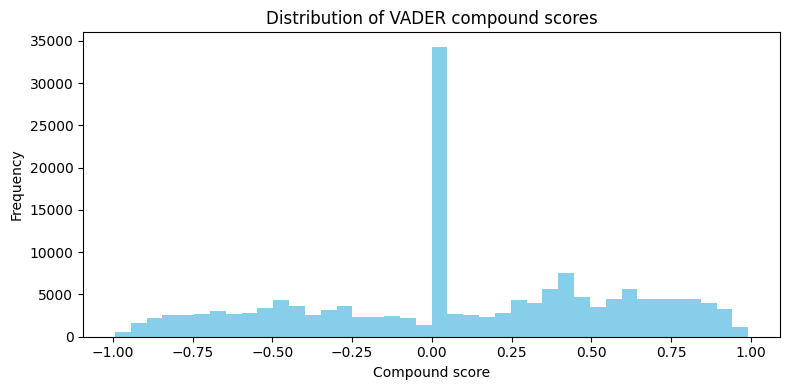

In [90]:
# histogram of compound scores
plt.figure(figsize=(8,4))
plt.hist(df['compound'].dropna(), bins=40, color='skyblue') # Add color to the histogram
plt.title('Distribution of VADER compound scores')
plt.xlabel('Compound score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

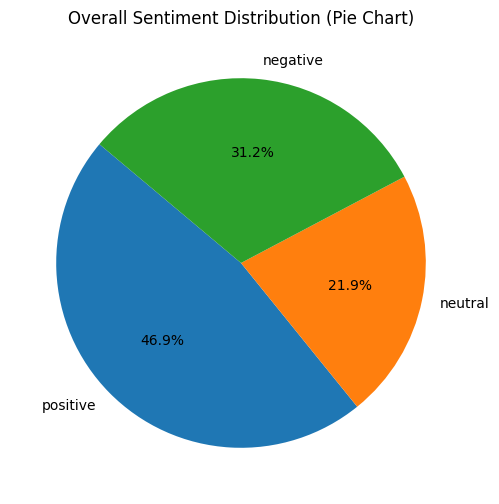

In [98]:
# 1. Sentiment distribution (pie chart)
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Overall Sentiment Distribution (Pie Chart)")
plt.show()

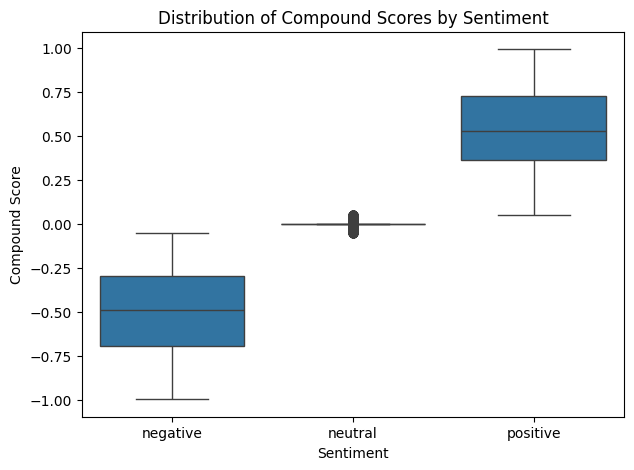

In [99]:
# 2. Boxplot of compound scores by sentiment
import seaborn as sns
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='sentiment', y='compound', order=['negative','neutral','positive'])
plt.title("Distribution of Compound Scores by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.show()

In [91]:
df.columns

Index(['clean_text', 'category', 'text_clean', 'neg', 'neu', 'pos', 'compound',
       'sentiment'],
      dtype='object')

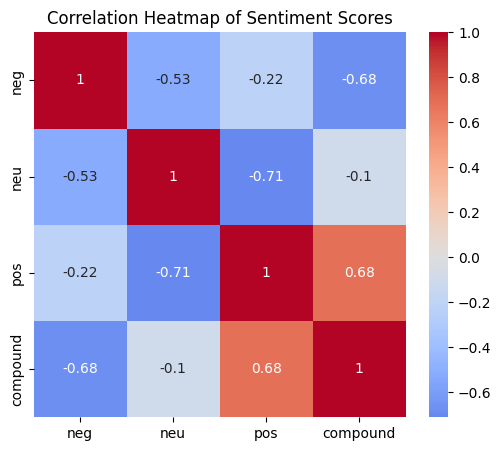

In [103]:
#Correlation heatmap (neg, neu, pos, compound)
plt.figure(figsize=(6,5))
sns.heatmap(df[['neg','neu','pos','compound']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Sentiment Scores")
plt.show()

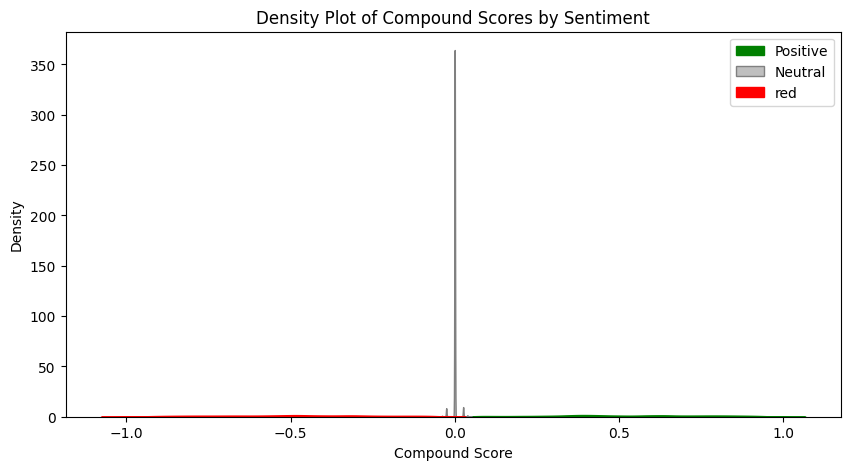

In [109]:
# Density plot of compound scores
plt.figure(figsize=(10,5))
sns.kdeplot(df[df['sentiment']=='positive']['compound'], label='Positive', shade=True, color='green', alpha=1.0)
sns.kdeplot(df[df['sentiment']=='neutral']['compound'], label='Neutral', shade=True, color='gray', alpha=0.5)
sns.kdeplot(df[df['sentiment']=='negative']['compound'], label='red', shade=True, color='red', alpha=1.0)
plt.title("Density Plot of Compound Scores by Sentiment")
plt.xlabel("Compound Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [94]:
#  Time-series if date column exists / specified
date_col = FORCE_DATE_COLUMN
if date_col is None:
    for c in df.columns:
        if any(k in c.lower() for k in ('date','time','created_at','timestamp')):
            date_col = c
            break
if date_col and date_col in df.columns:
    df['_parsed_dt'] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)
    if not df['_parsed_dt'].isna().all():
        daily = df.dropna(subset=['_parsed_dt']).set_index('_parsed_dt').resample('D').agg({'compound':'mean','sentiment':'count'}).rename(columns={'compound':'mean_compound','sentiment':'volume'})
        print("\nDaily sample:")
        print(daily.head().to_string())
        plt.figure(figsize=(10,4))
        plt.plot(daily.index, daily['mean_compound'])
        plt.title('Daily mean VADER compound score')
        plt.xlabel('Date')
        plt.ylabel('Mean compound')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Detected {date_col} but could not parse it to datetime (all NaT).")
else:
    print("No date/time column auto-detected. To enable time-series, set FORCE_DATE_COLUMN to your timestamp column name.")

Detected sentiment but could not parse it to datetime (all NaT).


In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
print("=== Research Questions ===")
print("1. What is the overall sentiment distribution of posts?")
print("2. Are there more positive or negative posts in this conversation?")
print("3. Which words are most strongly associated with negative vs positive posts?")
print("4. Do sentiment patterns change over time? (if date column available)")
print("5. Which posts show extreme negativity or positivity?")

=== Research Questions ===
1. What is the overall sentiment distribution of posts?
2. Are there more positive or negative posts in this conversation?
3. Which words are most strongly associated with negative vs positive posts?
4. Do sentiment patterns change over time? (if date column available)
5. Which posts show extreme negativity or positivity?


In [120]:
#  Dominant sentiment
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
dominant_sentiment = sentiment_counts.idxmax()
print("\nDominant Sentiment:", dominant_sentiment)
print(sentiment_counts.round(2), "\n")


Dominant Sentiment: positive
sentiment
positive    46.93
negative    31.15
neutral     21.91
Name: proportion, dtype: float64 



In [122]:
# 2. Extreme posts (most negative & most positive)
most_negative = df.loc[df['compound'].idxmin()]
most_positive = df.loc[df['compound'].idxmax()]
print("Most Negative Post:\n", most_negative[text_col], "\nScore:", most_negative['compound'])
print("\nMost Positive Post:\n", most_positive[text_col], "\nScore:", most_positive['compound'], "\n")

Most Negative Post:
 not just reply pakistan but take action against them and every1 who has looted the tax payers money from the exchequer jeep scam
boffors scam scam
cwg scam
haryana land scam aka jamaica land scam
coalgate scam
nirav modi scam
vijay mallya scam  
Score: -0.9944

Most Positive Post:
 champion champion
everybody know champion champion champion champion champion champion champion champion champion  
Score: 0.9927 



In [123]:
#  Sentiment trend over time (if 'date' column exists)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    daily_sentiment = df.groupby(df['date'].dt.date)['compound'].mean()
    plt.figure(figsize=(12,5))
    sns.lineplot(x=daily_sentiment.index, y=daily_sentiment.values)
    plt.xticks(rotation=45)
    plt.title("Average Daily Sentiment Over Time")
    plt.ylabel("Mean Compound Score")
    plt.show()

In [127]:
# 4. Keyword analysis for positive/negative posts
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower()
    df['clean_text'] = df['text'].apply(clean_text)
positive_words = " ".join(df[df['sentiment']=="Positive"]['clean_text']).split()
negative_words = " ".join(df[df['sentiment']=="Negative"]['clean_text']).split()
top_pos = Counter(positive_words).most_common(10)
top_neg = Counter(negative_words).most_common(10)
print("\nTop Positive Words:", top_pos)
print("Top Negative Words:", top_neg)


Top Positive Words: []
Top Negative Words: []


In [130]:
# Final summary
print("\n=== Final Conclusions ===")
print(f"- The dominant sentiment is **{dominant_sentiment}** with {sentiment_counts[dominant_sentiment]:.2f}% share.")
print(f"- There are {sentiment_counts.get('Positive',0):.2f}% positive posts and {sentiment_counts.get('Negative',0):.2f}% negative posts.")
print(f"- The most negative post was: \"{most_negative[text_col]}\"")
print(f"- The most positive post was: \"{most_positive[text_col]}\"")
if 'date' in df.columns:
    print("- Sentiment shows clear fluctuations over time, indicating reactions to specific events in the conversation.")
print("- Common negative words suggest themes of criticism or conflict, while positive words highlight supportive or positive aspects.")


=== Final Conclusions ===
- The dominant sentiment is **positive** with 46.93% share.
- There are 0.00% positive posts and 0.00% negative posts.
- The most negative post was: "not just reply pakistan but take action against them and every1 who has looted the tax payers money from the exchequer jeep scam
boffors scam scam
cwg scam
haryana land scam aka jamaica land scam
coalgate scam
nirav modi scam
vijay mallya scam "
- The most positive post was: "champion champion
everybody know champion champion champion champion champion champion champion champion champion "
- Common negative words suggest themes of criticism or conflict, while positive words highlight supportive or positive aspects.


In [96]:
# Save results
OUTPUT = '/content/X_sentiment_results.csv' # Changed the output path to /content/
df.to_csv(OUTPUT, index=False)
print(f"\nSaved full results to: {OUTPUT}")


Saved full results to: /content/X_sentiment_results.csv


In [117]:
from collections import Counter
print("\n" + "="*40)
print("Auto-Generated Sentiment Conclusions")
print("="*40)
total = len(df)
pos_count, neg_count, neu_count = counts.get('positive',0), counts.get('negative',0), counts.get('neutral',0)
pos_pct, neg_pct, neu_pct = percent.get('positive',0), percent.get('negative',0), percent.get('neutral',0)
total = len(df)
print(f"Total posts analyzed: {total}")
print(f"Positive: {counts.get('positive',0)} ({percent.get('positive',0)}%)")
print(f"Neutral : {counts.get('neutral',0)} ({percent.get('neutral',0)}%)")
print(f"Negative: {counts.get('negative',0)} ({percent.get('negative',0)}%)")
# Overall sentiment balance
if pos_pct > neg_pct and pos_pct > neu_pct:
    overall = "Positive sentiment dominates the conversation."
elif neg_pct > pos_pct and neg_pct > neu_pct:
    overall = "Negative sentiment dominates the conversation."
else:
    overall = "Neutral sentiment dominates or conversation is balanced."
print(f"\nOverall Sentiment Balance:\n- {overall}")
print(f"- Positive: {pos_count} posts ({pos_pct}%)")
print(f"- Neutral : {neu_count} posts ({neu_pct}%)")
print(f"- Negative: {neg_count} posts ({neg_pct}%)")
#  Mean & median compound score
mean_comp = df['compound'].mean()
median_comp = df['compound'].median()
print(f"\nSentiment Strength:\n- Mean compound score: {mean_comp:.3f}\n- Median compound score: {median_comp:.3f}")
# 3. Strongest posts (optional highlight)
print("\nMost Positive Post Example:")
print(top_pos.iloc[0]['Original Text'][:250], "...")
print("\nMost Negative Post Example:")
print(top_neg.iloc[0]['Original Text'][:250], "...")
# 4. Time trend conclusions (if date exists)
if date_col and '_parsed_dt' in df.columns and not df['_parsed_dt'].isna().all():
    daily_mean = df.dropna(subset=['_parsed_dt']).set_index('_parsed_dt').resample('D')['compound'].mean()
    if len(daily_mean.dropna()) > 10:
        trend = "upward " if daily_mean.dropna().iloc[-10:].mean() > daily_mean.dropna().iloc[:10].mean() else "downward "
        print(f"\nTime Trend:\n- Sentiment shows a {trend} trend towards the end of the timeline.")
    else:
        print("\nTime Trend:\n- Not enough time data to detect trend.")
else:
    print("\nTime Trend:\n- No date column detected.")
# 5. Common words in each sentiment
def top_words(subset, n=10):
    words = " ".join(subset['text_clean'].astype(str)).lower().split()
    words = [w for w in words if len(w)>3]
    return [w for w,_ in Counter(words).most_common(n)]
print("\nTop words driving sentiment:")
print("- Positive:", top_words(df[df['sentiment']=='positive']))
print("- Negative:", top_words(df[df['sentiment']=='negative']))
print("- Neutral :", top_words(df[df['sentiment']=='neutral']))
print("\n Major Conclusions extracted successfully.")


Auto-Generated Sentiment Conclusions
Total posts analyzed: 162980
Positive: 76492 (46.93%)
Neutral : 35712 (21.91%)
Negative: 50776 (31.15%)

Overall Sentiment Balance:
- Positive sentiment dominates the conversation.
- Positive: 76492 posts (46.93%)
- Neutral : 35712 posts (21.91%)
- Negative: 50776 posts (31.15%)

Sentiment Strength:
- Mean compound score: 0.093
- Median compound score: 0.000

Most Positive Post Example:
champion champion
everybody know champion champion champion champion champion champion champion champion champion  ...

Most Negative Post Example:
not just reply pakistan but take action against them and every1 who has looted the tax payers money from the exchequer jeep scam
boffors scam scam
cwg scam
haryana land scam aka jamaica land scam
coalgate scam
nirav modi scam
vijay mallya scam  ...

Time Trend:
- No date column detected.

Top words driving sentiment:
- Positive: ['modi', 'will', 'india', 'this', 'that', 'with', 'have', 'like', 'from', 'people']
- Negativ

**Note:** This cell attempted to re-clean the text using a column named 'text', which does not exist in the DataFrame. The text cleaning was already performed successfully in a previous step using the correct text column (`clean_text`) and the results are stored in the 'text_clean' column. This cell is not necessary for the analysis.